In [1]:
%matplotlib widget
import os, sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

In [3]:
def image2pixel(p, f, x_c, y_c, width, height):
    # output: coordinates in the image pixels crs which origin is upper left corner (cv standard axis directions)
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c]])
    p_n = K.dot([p[0], p[1], 1])
    return True, p_n

def distort(p, f, x_c, y_c, k1, k2, k3, t1, t2):
    # p is the image point's normalized coordinates
    # f is the focal length
    # x_c, y_c are the principle point from the image center
    
    r2 = p[0] * p[0] + p[1] * p[1]    
    rp = 1 + k1*r2 + k2*r2*r2 + k3*r2*r2*r2

    rx = p[0] * rp
    ry = p[1] * rp

    tx = t2 * (r2 + 2 * p[0] * p[0]) - 2 * t1 * p[0] * p[1];
    ty = - t1 * (r2 + 2 * p[1] * p[1]) + 2 * t2 * p[0] * p[1];
    
    x = rx + tx;
    y = ry + ty;
    
    return True, np.array([x, y])


In [4]:
def pixel2image(p_d, f, x_c, y_c, width, height):
    K = np.array([[f, 0, x_c + width/2.0], [0, -f, height/2.0 - y_c], [0, 0, 1]])
    p_u = np.linalg.inv(K).dot([p_d[0], p_d[1], 1])
    return True, p_u[:2]

def undistort(p, distort_fn, epsilon=1e-10, max_iter_num=10, verbose=False):
    
    p_u = p.copy()
    
    result, p_d_i = distort_fn(p_u);
    if result == False:
        print('Distortion is unsuccessful!')
        return False, np.one((2, 1)) * np.nan
    delta_p = p_d_i - p_u
    
    epsilon = 1e-10
    iter_num = 0
    while np.max(np.abs(p_u - (p - delta_p))) > epsilon and iter_num < max_iter_num:
        p_u = p - delta_p
        result, p_d_i = distort_fn(p_u)
        if result == False:
            print('Distortion is unsuccessful!')
            return False, np.one((2, 1)) * np.nan
        delta_p = p_d_i - p_u
        iter_num += 1
        
        if verbose:
            num2str = lambda x: str(round(x, 10))
            print('#' + num2str(iter_num) + " x=" + num2str(p_u[0]) + 
                  " y=" + num2str(p_u[0]) + " delta=" + num2str(np.max(np.abs(p_u - (p - delta_p)))))
    
    if iter_num == max_iter_num:
        print('Did not converge!')
        return False, p_u
    
    return True, p_u

In [5]:
def backproject(P_w, C, R, camera2pixel):
    P_c = R @ P_w - R @ C
    
    if P_c[2] == 0:
        print('Divider is zero!')
        return False, np.ones((1, 2)) * np.nan
    
    #p_n = [-P_c[0]/P_c[2], -P_c[1]/P_c[2]]
    p_n = [P_c[0]/P_c[2], P_c[1]/P_c[2]]
    result, p_d = camera2pixel(p_n)

    if result == False:
        return False, p_d
        
    if (p_d[0] >= 0 and p_d[0] <= width and p_d[1] >= 0 and p_d[1] <= height and 
        f*p_n[0] > -width/2.0*1.25 and f*p_n[0] < width/2.0*1.25 and
        f*p_n[1] > -height/2.0*1.25 and f*p_n[1] < height/2.0*1.25):
        return True, p_d
    else:
        return False, p_d

## Problem definiation

In [6]:
# image/camera parameters
pixel_size = 1.88e-6 # [mm]
width = 4000
height = 3000
f = 2873.58 
x_c = 0
y_c = 0

camera2pixel = lambda p: image2pixel(p, f, x_c, y_c, width, height)
pixel2camera = lambda p: pixel2image(p, f, x_c, y_c, width, height)

In [7]:
R0 = np.eye(3)
t0 = np.zeros((3,))
C0 = -R0 @ t0
print(C0)

t_rel = np.array([-10, -20, 5])
R_rel = Rotation.from_euler('ZYX', [45, -10, -10], degrees=True).as_matrix()

R1 = R0 @ R_rel.T
t1 = t0 - t_rel
C1 = -R1 @ t1
print(C1)

R_gt = R_rel
t_gt = t_rel / np.linalg.norm(t_rel)

[0. 0. 0.]
[-20.02268632  -8.45834911   7.24902495]


In [8]:
P_w_list = np.random.rand(8,3) 
P_w_list[:, 0] = (P_w_list[:, 0] * 10 - 5 + C1[0]/2)
P_w_list[:, 1] = (P_w_list[:, 1] * 10 - 5 + C1[1]/2)
P_w_list[:, 2] = -(P_w_list[:, 2] * 10 + 35)
print(P_w_list)

[[-12.12658122  -5.76576147 -41.41171671]
 [-13.50825514  -1.69746433 -36.81192209]
 [ -8.31522754  -2.36994821 -41.14013877]
 [ -5.94765266  -4.78388393 -44.99777038]
 [ -8.52347379  -3.25850385 -40.02691797]
 [ -6.73289047  -1.77441905 -37.0760081 ]
 [-14.11748765  -2.34055294 -39.43570523]
 [-14.33191755  -3.29459202 -39.18117064]]


In [9]:
p1_list = []
p2_list = []
p1_n_list = []
p2_n_list = []
for idx, P_w in enumerate(P_w_list):
    
    is_on_image, p1 = backproject(P_w, C0, R0, camera2pixel)
    p1_list.append(p1)

    _, p1_n = pixel2camera(p1)
    #if not is_on_image:
    #    print('{}th point is not on the 1st image!'.format(idx))
    p1_n_list.append(p1_n)

    is_on_image, p2 = backproject(P_w, C1, R_rel, camera2pixel)
    p2_list.append(p2)
    _, p2_n = pixel2camera(p2)

    #if not is_on_image:
    #    print('{}th point is not on the 2nd image!'.format(idx))
    p2_n_list.append(p2_n)
    
p1_n_list = np.array(p1_n_list)
p2_n_list = np.array(p2_n_list)

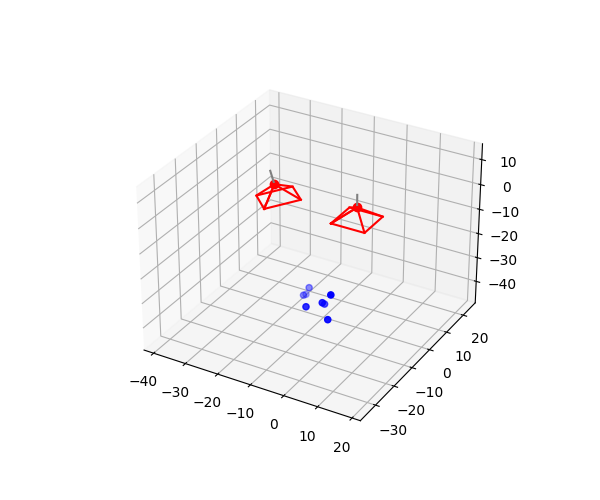

In [10]:
plt.figure(figsize=(6,5))
#plt.title('The problem')
ax = plt.axes(projection='3d')
ax.scatter3D(C0[0], C0[1], C0[2], c='r', s=0.1)
plot_fustrum(ax, C0, R0, f=-1, scale=5)
plot_fustrum(ax, C1, R_rel, f=-1, scale=5)
ax.scatter3D(P_w_list[:, 0], P_w_list[:, 1], P_w_list[:, 2], c='b', s=20)
set_3d_axes_equal(ax)

Text(0.5, 1.0, '2nd image')

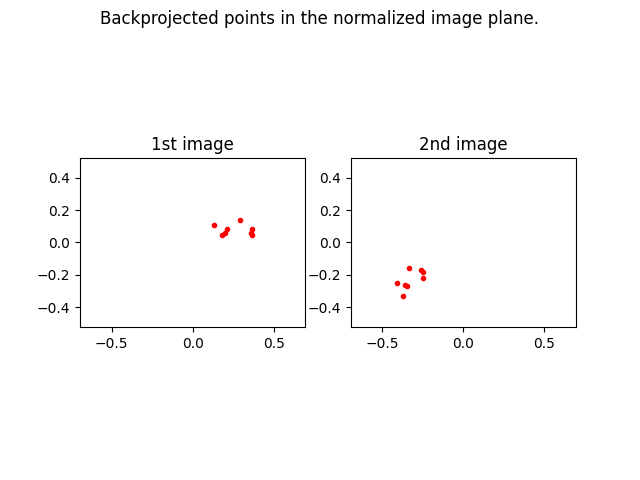

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Backprojected points in the normalized image plane.')
ax1.plot(p1_n_list[:, 0], p1_n_list[:, 1], 'r.')
ax1.set_xlim([-width/f/2, width/f/2])
ax1.set_ylim([-height/f/2, height/f/2])
ax1.set_aspect('equal')
ax1.set_title('1st image')

ax2.plot(p2_n_list[:, 0], p2_n_list[:, 1], 'r.')
ax2.set_aspect('equal')
ax2.set_xlim([-width/f/2, width/f/2])
ax2.set_ylim([-height/f/2, height/f/2])
ax2.set_title('2nd image')


## Essential matrix estimation

Find $E \in \mathbb{R}^{3\times3}$ where 
$$
p'Ep = 0
$$

and where $E$ satsifies two constraints:

$$
det(E) = 0
$$

$$
E E^T E - \frac{1}{2} trace(EE^T) E = 0
$$

The first constraint provides that the matrix has rank 2 and the second constraint states that the first two non zero singular values are equal.

## 5-point algorithm

One of the most used minimal solver is called the Nister's 5-point algorithm. The algorithm is quite complicated, we can find it in Nister's original paper titled "An Efficient Solution to the Five-Point Relative Pose Problem": http://www.cad.zju.edu.cn/home/gfzhang/training/SFM/2004-PAMI-David%20Nister-An%20Efficient%20Solution%20to%20the%20Five-Point%20Relative%20Pose%20Problem.pdf


In [12]:
import cv2
E_solutions, mask = cv2.findEssentialMat(p1_n_list[:5, :], p2_n_list[:5, :], focal=1, pp=(0, 0))

In [13]:
n_solution = int(E_solutions.shape[0]/3)
print('Number of Essential matrix solutions: ', n_solution)
for k in range(n_solution): 
    E = E_solutions[k*3:k*3+3, 0:3]
    
    points, R_hat, t_hat, mask = cv2.recoverPose(E[:3, :3], p1_n_list, p2_n_list)
    t_hat = t_hat.reshape((3, ))

    if np.linalg.norm(R_hat-R_gt) < 1e-6 and np.linalg.norm(t_hat-t_gt) < 1e-6:
        E_hat = E
        print(' ')
        print('Solution #', k+1)
        print('E: ', E)
        print('delta R:', np.linalg.norm(R_hat-R_gt))
        print('delta t:', np.linalg.norm(t_hat-t_gt))
        print('t_hat:', t_hat.T)
        print('t_gt :', t_gt)


Number of Essential matrix solutions:  4
 
Solution # 1
E:  [[-0.21462932 -0.00519166 -0.59888998]
 [ 0.16104033 -0.15693615  0.26169577]
 [ 0.21490267 -0.63812794 -0.15099687]]
delta R: 5.4182409810088285e-15
delta t: 7.718645429844055e-15
t_hat: [-0.43643578 -0.87287156  0.21821789]
t_gt : [-0.43643578 -0.87287156  0.21821789]


## 8-point algorithm

Following wikipedia article for implementation: https://en.wikipedia.org/wiki/Eight-point_algorithm.

In [14]:
import sympy
from sympy import symbols

p1 = np.array([symbols('x1'), symbols('y1'), 1]).reshape(3, 1)
p2 = np.array([symbols('x2'), symbols('y2'), 1]).reshape(3, 1)
E = sympy.Matrix([[symbols('e11'), symbols('e12'), symbols('e13')], 
             [symbols('e21'), symbols('e22'), symbols('e23')], 
             [symbols('e31'), symbols('e32'), symbols('e33')]])

fn = p2.T @ E @ p1
fn = sympy.factor(fn[0])
print('Equation: ', str(fn))

Equation:  e11*x1*x2 + e12*x2*y1 + e13*x2 + e21*x1*y2 + e22*y1*y2 + e23*y2 + e31*x1 + e32*y1 + e33


In [15]:
A = []
for k in range(p1_n_list.shape[0]):
    x1 = p1_n_list[k, 0]
    y1 = p1_n_list[k, 1]
    x2 = p2_n_list[k, 0]
    y2 = p2_n_list[k, 1]

    A.append([x1*x2, x2*y1, x2, x1*y2, y1*y2, y2, x1, y1, 1])

A = np.array(A)

In [16]:
U, S, V = np.linalg.svd(A)
V = -V.T
E_hat_8 = V[:, -1].reshape(3, 3)
print(E_hat_8)

[[ 0.21462932  0.00519166  0.59888998]
 [-0.16104033  0.15693615 -0.26169577]
 [-0.21490267  0.63812794  0.15099687]]


In [17]:
def check_E(E):
    points, R_hat, t_hat, mask = cv2.recoverPose(E, p1_n_list, p2_n_list)
    t_hat = t_hat.reshape((3, ))
    print('delta R:', np.linalg.norm(R_hat-R_gt))
    print('delta t:', np.linalg.norm(t_hat-t_gt))

check_E(E_hat_8)

delta R: 6.155130417460071e-14
delta t: 1.0576185515301696e-14


In [18]:
print('det(E): ', np.linalg.det(E_hat_8))
print('Singular value contraints (=0): ', 
      np.linalg.norm(E_hat_8 @ E_hat_8.T @ E_hat_8 - 0.5*np.trace(E_hat_8 @ E_hat_8.T) * E_hat_8))

_, S_chk, _ = np.linalg.svd(E_hat_8)
print('First two singular values are equal (=0): ', S_chk[0] - S_chk[1])
print('Third singular value is zero (=0): ', S_chk[2])

det(E):  -7.12825904689716e-15
Singular value contraints (=0):  2.5105320896141612e-14
First two singular values are equal (=0):  3.4083846855992306e-14
Third singular value is zero (=0):  1.4255224544389354e-14


8-point algorithm is sensitive for noise, so if we try to solve non-minimal problems we have to be careful. We can improve the "robustness" of the algorithm by "normalizing" the input coordinates".

## 7-point algorithm

### Solution using the symbolic library

Similar to the 8 point algorithm we have the equality conditations:

In [19]:
A = []
for k in range(7):
    x1 = p1_n_list[k, 0]
    y1 = p1_n_list[k, 1]
    x2 = p2_n_list[k, 0]
    y2 = p2_n_list[k, 1]

    A.append([x1*x2, x2*y1, x2, x1*y2, y1*y2, y2, x1, y1, 1])

A = np.array(A)

This matrix however has rank 2 deficiency:

In [36]:
from scipy.linalg import lu
pl, u = lu(A, permute_l=True)
np.set_printoptions(precision=4, suppress=True)
print(u)

[[-0.0983 -0.0467 -0.3358 -0.0464 -0.0221 -0.1586  0.2928  0.1392  1.    ]
 [ 0.      0.0322  0.0634 -0.0365  0.0106 -0.0694  0.0932 -0.0841  0.0651]
 [ 0.      0.     -0.19   -0.028  -0.0088 -0.2036  0.0223 -0.0172  0.4843]
 [ 0.      0.      0.      0.0128  0.0018  0.0128 -0.0594  0.0056 -0.0744]
 [ 0.      0.      0.      0.     -0.002  -0.0075 -0.0244 -0.0001 -0.0451]
 [ 0.      0.      0.      0.      0.     -0.0271 -0.0298 -0.0005 -0.0873]
 [ 0.      0.      0.      0.      0.      0.      0.0412  0.0014  0.0526]]


Let's use symbolic computation to find the free parameters:

In [37]:
Us = sympy.Matrix(A)
B = sympy.zeros(7, 1)
e1 = Us.gauss_jordan_solve(B)

e1[0]

Matrix([
[   0.696453387790928*tau0 - 1.5218662452186*tau1],
[   1.97500559318407*tau0 - 8.31218915348298*tau1],
[-0.0309713870380802*tau0 + 4.09712910309936*tau1],
[ -0.657049484343323*tau0 + 1.71024272438472*tau1],
[  0.287677773677555*tau0 - 0.17642134931014*tau1],
[ 0.0188008639780049*tau0 - 1.81257479445473*tau1],
[-0.0341654944235395*tau0 - 1.27883914837898*tau1],
[                                            tau0],
[                                            tau1]])

The last element of the Essential matrix is 1:

In [38]:
e = e1[0].subs({'tau1': 1})
e

Matrix([
[   0.696453387790928*tau0 - 1.5218662452186],
[   1.97500559318407*tau0 - 8.31218915348298],
[ 4.09712910309936 - 0.0309713870380802*tau0],
[  1.71024272438472 - 0.657049484343323*tau0],
[  0.287677773677555*tau0 - 0.17642134931014],
[ 0.0188008639780049*tau0 - 1.81257479445473],
[-0.0341654944235395*tau0 - 1.27883914837898],
[                                       tau0],
[                                          1]])

Let's use the $det(E) = 0$ constraint that leads us to a 3rd order polynomial, a.k.a the cubic constraints:

In [39]:
cubic_const = e.reshape(3, 3).det()
cubic_const

0.00568277474503978*tau0**3 + 0.153254267492703*tau0**2 + 0.601399063854265*tau0 - 5.70760581881469

Get the coeffcients of the polynomial from the symbolic expression:

In [41]:
coeffs = sympy.Poly(cubic_const).coeffs()
roots = np.roots(coeffs)
roots = roots[~np.iscomplex(roots)].real
print('Solution of the cubic constraints: ', roots)

Solution of the cubic constraints:  [-17.9662 -13.2281   4.2261]


Pick the solution which satsifies the singular value constraint: 

In [42]:
for root in roots:
    e_cand = np.array(e.subs({'tau0': root})).astype(np.float64)
    E_hat_7_cand = e_cand.reshape(3, 3)
    
    s2_chk = np.linalg.norm(E_hat_7_cand @ E_hat_7_cand.T @ E_hat_7_cand - 0.5*np.trace(E_hat_7_cand @ E_hat_7_cand.T) * E_hat_7_cand)
    if s2_chk < 1e-6: # pick the solution where the two singular values are equal
        E_hat_7 = E_hat_7_cand
        print(' ')
        print('Solution #', k)
        check_E(E_hat_7)

 
Solution # 2
delta R: 3.4832505176863974e-13
delta t: 1.947076023685058e-13


### Solution using nullspace vectors

In the previous solution we needed to use symbolic computations. Now let's see another approach to avoid using the symbolic library. We will need th nullspace vectors:

In [26]:
U, S, V = np.linalg.svd(A)
V = V.T
null_space_A = V[:, -2:]

In [27]:
from scipy.linalg import null_space
print('null_space check: ', np.linalg.norm(null_space(A) - null_space_A))

null_space check:  2.0054373363378684e-14


In [28]:
F1 = null_space_A[:, 0].reshape(3,3)
F2 = null_space_A[:, 1].reshape(3,3)

If F1 or F2 has rank-2, we already have the solution:

In [29]:
if np.linalg.matrix_rank(F1) == 2:
    print('F1 is the solution.')
elif np.linalg.matrix_rank(F2) == 2:
    print('F2 is the solution.')

In [30]:
c = symbols('c') 
print('The cubic equation: ', sympy.Matrix(F1 + c*F2).det())

The cubic equation:  0.00283079772882067*c**3 - 0.0151741916870176*c**2 + 0.0195470763347649*c + 0.00197035313411888


In [31]:
a0 = np.linalg.det(F1)
a1 = np.linalg.det(F1)*np.trace(F2 @ np.linalg.inv(F1))
a2 = np.linalg.det(F2)*np.trace(F1 @ np.linalg.inv(F2))
a3 = np.linalg.det(F2)
print([a3, a2, a1, a0])

[0.0028307977288206695, -0.015174191687017632, 0.019547076334764903, 0.0019703531341188924]


In [35]:
roots = np.roots([a0, a1, a2, a3])
roots = roots[~np.iscomplex(roots)].real
print('Roots:', roots)

Roots: [-10.656    0.3868   0.3485]


In [33]:
for k, root in enumerate(roots):
    E_hat_7_cand = (root*F1 + F2)
    
    s2_chk = np.linalg.norm(E_hat_7_cand @ E_hat_7_cand.T @ E_hat_7_cand - 0.5*np.trace(E_hat_7_cand @ E_hat_7_cand.T) * E_hat_7_cand)
    if s2_chk < 1e-6: # pick the solution where the two singular values are equal
        E_hat_7 = E_hat_7_cand
        print(' ')
        print('Solution #', k)
        check_E(E_hat_7)

 
Solution # 0
delta R: 2.6506667715738337e-13
delta t: 1.6091681489917606e-13


In [34]:
print('det(E): ', np.linalg.det(E_hat_7))
print('Singular value contraints (=0): ', 
      np.linalg.norm(E_hat_7 @ E_hat_7.T @ E_hat_7 - 0.5*np.trace(E_hat_7 @ E_hat_7.T) * E_hat_7))

_, S_chk, _ = np.linalg.svd(E_hat_7)
print('First two singular values are equal (=0): ', S_chk[0] - S_chk[1])
print('Third singular value is zero (=0): ', S_chk[2])

det(E):  1.4047987278034747e-14
Singular value contraints (=0):  1.8432819769166228e-10
First two singular values are equal (=0):  2.2710722191732202e-12
Third singular value is zero (=0):  4.0503180058388656e-16
